In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 

In [2]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
data.shape

(566134, 6)

In [63]:
click_diff = data[data.slot == 'exp'].n_clicks.sum() * 100 / data[data.slot == 'control'].n_clicks.sum() - 100
round(click_diff, 3)

1.614

In [11]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def bootstrap_stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return tuple(boundaries)

In [13]:
np.random.seed(0)

click_med_ctrl = list(map(np.median, get_bootstrap_samples(data[data.slot == 'control'].n_clicks.values, 1000)))
click_med_exp = list(map(np.median, get_bootstrap_samples(data[data.slot == 'exp'].n_clicks.values, 1000)))

click_avg_ctrl = list(map(np.mean, get_bootstrap_samples(data[data.slot == 'control'].n_clicks.values, 1000)))
click_avg_exp = list(map(np.mean, get_bootstrap_samples(data[data.slot == 'exp'].n_clicks.values, 1000)))

In [21]:
delta_med_scores = list(map(lambda x: x[1] - x[0], zip(click_med_ctrl, click_med_exp)))
delta_avg_scores = list(map(lambda x: x[1] - x[0], zip(click_avg_ctrl, click_avg_exp)))

In [22]:
bootstrap_stat_intervals(delta_med_scores)

(1.0, 1.0)

In [23]:
bootstrap_stat_intervals(delta_avg_scores)

(0.19809869991622966, 0.4088038302380582)

In [24]:
np.random.seed(0)
n_boot_samples = 500
ctrl_samples = get_bootstrap_samples(data[data.slot == 'control'].n_clicks.values, n_boot_samples)

In [25]:
ctrl_avg_sample = [np.mean(x) for x in ctrl_samples]
ctrl_chi_squares = []
for idx, avg in enumerate(ctrl_avg_sample):
    sq = 0
    for x in ctrl_samples[idx]:
        sq += (avg - x) ** 2
    ctrl_chi_squares.append(sq)

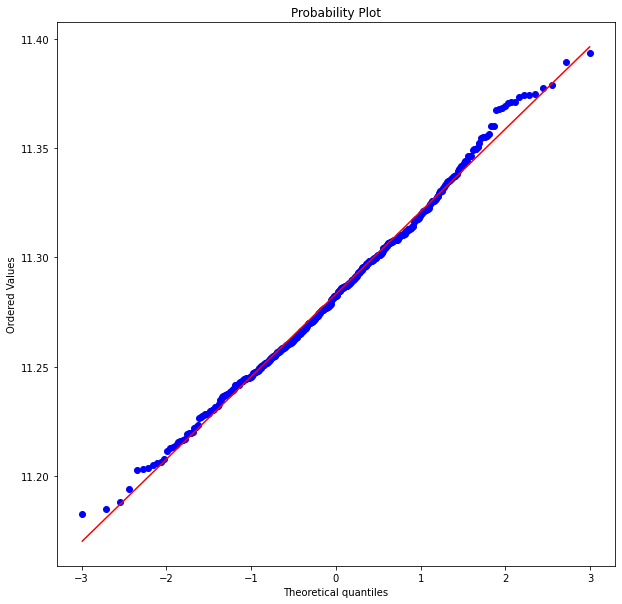

In [41]:
plt.figure(figsize=(10, 10))
avg_probplot_res = stats.probplot(ctrl_avg_sample, plot=plt, fit=True)

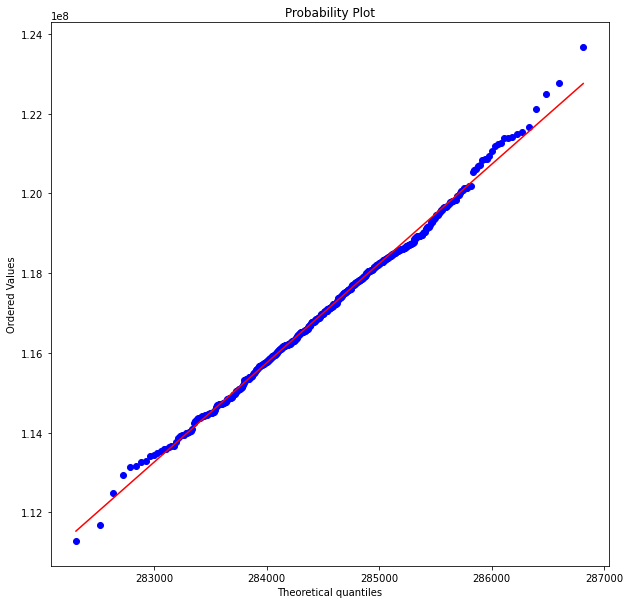

In [42]:
plt.figure(figsize=(10, 10))
chi2_probplot_res = stats.probplot(
    ctrl_chi_squares, dist='chi2', sparams=len(ctrl_samples[0]) - 1,
    plot=plt, fit=True,
)

In [45]:
avg_probplot_res[1][2]

0.9979748364604202

In [44]:
chi2_probplot_res[1][2]

0.9982571895783977

In [46]:
ctrl_data = data[data.slot == 'control']
ctrl_data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
3,6,Browser #4,control,12,6,0
5,8,Browser #4,control,4,4,1
7,10,Browser #4,control,22,15,2
9,15,Browser #14,control,2,2,0
13,23,Browser #4,control,3,1,0


In [47]:
exp_data = data[data.slot == 'exp']
exp_data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
4,7,Browser #4,exp,54,68,30
6,9,Browser #4,exp,6,3,1


In [48]:
ctrl_user_clicks = ctrl_data.groupby('userID').n_clicks.agg(['sum'])
ctrl_user_clicks.head()

,sum
userID,
6,12
8,4
10,22
15,2
23,3


In [49]:
exp_user_clicks = exp_data.groupby('userID').n_clicks.agg(['sum'])
exp_user_clicks.head()

,sum
userID,
1,23
3,3
5,29
7,54
9,6


In [50]:
stats.mannwhitneyu(exp_user_clicks, ctrl_user_clicks, alternative='two-sided')

MannwhitneyuResult(statistic=array([4.11408685e+10]), pvalue=array([8.69429438e-75]))

In [52]:
browser_p_values = {}
for bro_name in data.browser.unique():
    res = stats.mannwhitneyu(exp_data[exp_data.browser == bro_name].n_clicks, ctrl_data[ctrl_data.browser == bro_name].n_clicks)
    browser_p_values[bro_name] = res.pvalue

In [53]:
browser_p_values

{'Browser #2': 0.0544877208394482,
 'Browser #4': 0.8152123531690997,
 'Browser #14': 0.0,
 'Browser #17': 0.07480120286021603,
 'Browser #20': 0.9073331277747075,
 'Browser #22': 0.5148110304420064}

In [57]:
reject, p_corrected, a1, a2 = multipletests(
    list(browser_p_values.values()), 
    alpha=0.05, 
    method='holm',
)

In [58]:
p_corrected

array([0.2724386 , 1.        , 0.        , 0.29920481, 1.        ,
       1.        ])

In [62]:
for bro_name in data.browser.unique():
    ctrl_bro_data = ctrl_data[ctrl_data.browser == bro_name]
    exp_bro_data = exp_data[exp_data.browser == bro_name]
    
    ctrl_res = ctrl_bro_data.n_nonclk_queries.sum() * 100 / ctrl_bro_data.n_queries.sum()
    exp_res = exp_bro_data.n_nonclk_queries.sum() * 100 / exp_bro_data.n_queries.sum()
    
    print(bro_name, exp_res - ctrl_res)

Browser #2 -0.9800002306399449
Browser #4 -1.8279877315580677
Browser #14 -13.834793998807847
Browser #17 0.638046102382738
Browser #20 -1.5631082596661372
Browser #22 -0.7400293738178902
